In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

%matplotlib inline

In [12]:
import os
import re
import timeit

import numpy as np
import cv2

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class VehicleClassifier(object):
    
    def __init__(self):
        self.clf = SVC(verbose=True)
    
    def _os_walk(self, _dir):
        matches = []
        
        img_re = re.compile(r'.+\.(jpg|png|jpeg|tif|tiff)$', re.IGNORECASE)
        
        for root, dirnames, filenames in os.walk(_dir):
            matches.extend(os.path.join(root, name) for name in filenames if img_re.match(name))
        
        return matches
    
    def load_non_vehicle_images(self):
        return self._os_walk("./non-vehicles")[:10]
    
    def load_vehicle_images(self):
        return self._os_walk("./vehicles")[:10]
    
    def bin_spatial_features(self, img, size):
        # Use cv2.resize().ravel() to create the feature vector
        features = img.ravel()
        
        # Return the feature vector
        return features
    
    def color_hist_features(self, img, nbins=32, bins_range=(0, 256)):
        
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    

    def hog_features(self, img, blockSize=(16, 16), blockStride=(8,8),
                            cellSize=(8,8), winSize=(64, 64), nbins=9,
                            derivAperture=1, winSigma=4., histogramNormType=0,
                            L2HysThreshold=2.0000000000000001e-01,
                            gammaCorrection=0, nlevels=64, winStride=(8,8),
                            padding=(8,8), locations=((10,20),),
                            orient=9, pix_per_cell=8, cell_per_block=2):
        
#         hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins,
#                                     derivAperture, winSigma, histogramNormType,
#                                     L2HysThreshold, gammaCorrection, nlevels)

        img_shape = img.shape

        cell_size = (pix_per_cell, pix_per_cell)  # h x w in pixels
        
        block_size = (cell_per_block, cell_per_block)  # h x w in cells
        
        nbins = orient  # number of orientation bins
        
        hog = cv2.HOGDescriptor(_winSize=(img_shape[1] // cell_size[1] * cell_size[1],
                                          img_shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)
            
        #compute(img[, winStride[, padding[, locations]]]) -> descriptors
#         t = hog.compute(img, winStride, padding, locations)[:,0]
#         print(t.shape)
#         return hog.compute(img, winStride, padding, locations)[:,0]
        return hog.compute(img)[:,0]
    
    def extract_features(self, images, cls, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
        
        # Create a list to append feature vectors to
        features = []
        
        # Iterate through the list of images
        for file in images:
            # Read in each one by one
            image = cv2.imread(file)
            
            # apply color conversion if other than 'RGB'
            if cspace != 'RGB':
                if cspace == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                elif cspace == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
                elif cspace == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
                elif cspace == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            
            else: feature_image = np.copy(image)      
                
            # Apply bin_spatial() to get spatial color features
            spatial_features = self.bin_spatial_features(feature_image, spatial_size)
            
            # Apply color_hist() also with a color space option now
            hist_features = self.color_hist_features(feature_image, nbins=hist_bins, bins_range=hist_range)
            
            # Apply hog_features() also to get shape related featuers
            hog_features = self.hog_features(feature_image)

            # Append the new feature vector to the features list
            features.append(np.concatenate((spatial_features, hist_features, hog_features)))
#             features.append(spatial_features)
        
        
        # Return list of feature vectors and equal length labels
        return (features, [cls] * len(features))
    
    
    
    def load_data(self):
        def shuffle(x, y):
            perm = np.arange(len(x))
            np.random.shuffle(perm)
            x = x[perm]
            y = y[perm]

            return (x, y)
    
        print("loading vehicle images")

        vehicle_images = self.load_vehicle_images()
        
        print("load non-vehicle images")

        non_vehicle_images = self.load_non_vehicle_images()
        
        print("extract vehicle features")

        vehicle_features, y_vehicles = self.extract_features(vehicle_images, 1)
        
        print("extract non-vehicle features")

        n_vehicle_features, y_n_vehicles = self.extract_features(non_vehicle_images, 0)
        
        assert len(vehicle_features) == len(y_vehicles), 'vehicle features and labels are imbalanced'
        
        assert len(n_vehicle_features) == len(y_n_vehicles), 'non vehicle features and labels are imbalanced'
        
        count = min(len(vehicle_features), len(n_vehicle_features))
        
        vehicle_features = vehicle_features[:count]
        
        n_vehicle_features = n_vehicle_features[:count]

        y_vehicles = y_vehicles[:count]

        y_n_vehicles = y_n_vehicles[:count]
        
        x = np.vstack((vehicle_features, n_vehicle_features)).astype(np.float64)
        
        x = x.reshape((x.shape[0], -1), order='F')
        
        y = np.concatenate((y_vehicles, y_n_vehicles))
        
        print("normalize features")

        x_scaler = StandardScaler().fit(x)
        
        scaled_x = x_scaler.transform(x)
        
        print("shuffle data")

        X, Y = shuffle(scaled_x, y)

        print("train / test split")
        
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        
#         return (vehicle_features, n_vehicle_features, y_train, y_test)

        return vehicle_features, n_vehicle_features
    
    def calc_accuracy(self, y_true, y_pred):
        return accuracy_score(y_true, y_pred)

def main():
    vc = VehicleClassifier()
    
    x, y = vc.load_data()
    
    return x, y

In [13]:
x, y = main()

loading vehicle images
load non-vehicle images
extract vehicle features
extract non-vehicle features
normalize features
shuffle data
train / test split


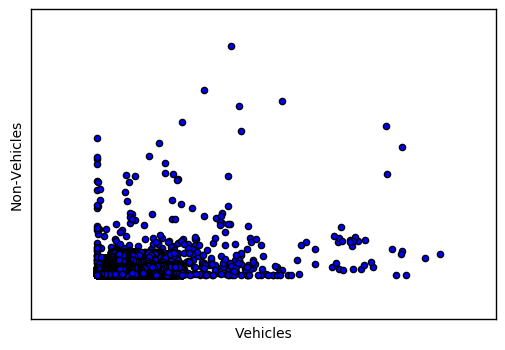

In [14]:
# Plot the training points
plt.scatter(x, y, cmap=plt.cm.Paired)
plt.xlabel('Vehicles')
plt.ylabel('Non-Vehicles')

plt.xticks(())
plt.yticks(())
plt.show()

In [42]:
vc = VehicleClassifier()

print("loading vehicle images")

vehicle_images = vc.load_vehicle_images()[:1]
        
print("load non-vehicle images")

non_vehicle_images = vc.load_non_vehicle_images()[:1]

vbins = []
for img in vehicle_images:
    image = cv2.imread(img)
    image = cv2.resize(image, (32, 32))
    vbins.append(vc.bin_spatial_features(image, None))

nvbins = []
for img in non_vehicle_images:
    image = cv2.imread(img)
    image = cv2.resize(image, (32, 32))
    nvbins.append(vc.bin_spatial_features(image, None))

loading vehicle images
load non-vehicle images


In [50]:
vc = VehicleClassifier()

print("loading vehicle images")

vehicle_images = vc.load_vehicle_images()[:10]
        
print("load non-vehicle images")

non_vehicle_images = vc.load_non_vehicle_images()[:10]

vbins = []
for img in vehicle_images:
    image = cv2.imread(img)
#     image = cv2.resize(image, (32, 32))
    vbins.append(vc.hog_features(image))

nvbins = []
for img in non_vehicle_images:
    image = cv2.imread(img)
#     image = cv2.resize(image, (32, 32))
    nvbins.append(vc.hog_features(image))

loading vehicle images
load non-vehicle images


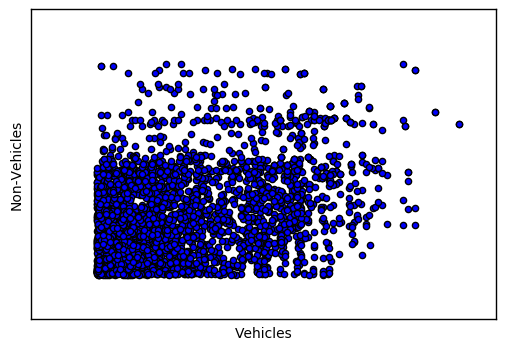

In [51]:
# Plot the training points
plt.scatter(vbins, nvbins, cmap=plt.cm.Paired)
plt.xlabel('Vehicles')
plt.ylabel('Non-Vehicles')

plt.xticks(())
plt.yticks(())
plt.show()

loading vehicle images
load non-vehicle images
extract vehicle features
extract non-vehicle features
normalize features
shuffle data
train / test split


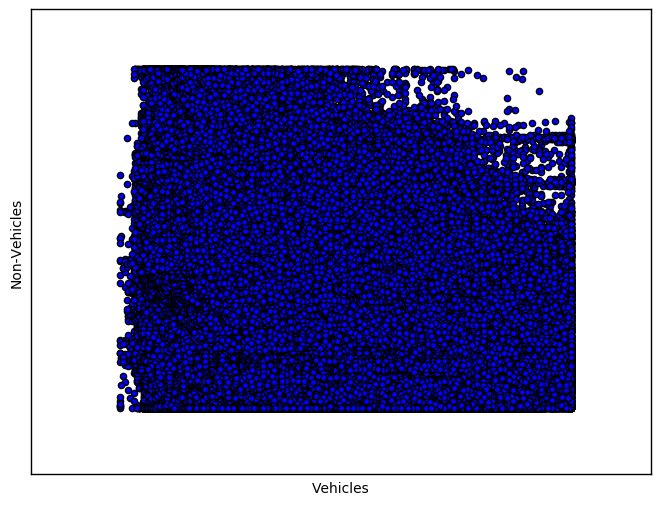

In [26]:

vehicle_features, n_vehicle_features, Y = main()

# x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
# y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(vehicle_features, n_vehicle_features, cmap=plt.cm.Paired)
plt.xlabel('Vehicles')
plt.ylabel('Non-Vehicles')

# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
# fig = plt.figure(1, figsize=(8, 6))
# ax = Axes3D(fig, elev=-150, azim=110)
# X_reduced = PCA(n_components=3).fit_transform(iris.data)
# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
#            cmap=plt.cm.Paired)
# ax.set_title("First three PCA directions")
# ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])
# ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])
# ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

plt.show()